# 🧪 Feature Opcional: Descripción del Puesto como Texto

En este notebook incorporamos una **feature opcional** basada en la columna `Description`, que contiene un texto libre con información semiestructurada del puesto.

Usaremos **TF-IDF** para vectorizar el texto y luego **SVD (TruncatedSVD)** para reducir la dimensionalidad. Esta feature se agregará al conjunto de datos original y se evaluará su impacto en el modelo.


✅ CELDA 2 – Imports + NLTK

In [3]:
import pandas as pd
import numpy as np
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Adrian\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


✅ CELDA 3 – Carga del dataset limpio

In [8]:
df = pd.read_csv('../data/df_clean.csv')


In [10]:
import pandas as pd

# Volvemos a cargar los datos y limpiamos igual que antes
people = pd.read_csv('../data/people.csv')
salary = pd.read_csv('../data/salary.csv')
descriptions = pd.read_csv('../data/descriptions.csv')

df = people.merge(salary, on='id').merge(descriptions, on='id')

# Rellenar valores faltantes y normalizar texto
df['Education Level'] = df['Education Level'].fillna('unknown')
df['Gender'] = df['Gender'].fillna('unknown')

for col in ['Gender', 'Education Level', 'Job Title']:
    df[col] = df[col].str.strip().str.lower()

# Guardamos como df_clean
df_clean = df.copy()


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

df = df_clean.dropna(subset=['Description', 'Salary'])

tfidf = TfidfVectorizer(max_features=100, stop_words='english')
X_tfidf = tfidf.fit_transform(df['Description'])

print("Shape de la matriz TF-IDF:", X_tfidf.shape)


Shape de la matriz TF-IDF: (370, 100)


In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

# 🔹 1. Filtrar valores nulos en todas las columnas necesarias
required_cols = ['Age', 'Years of Experience', 'Gender', 'Education Level', 'Job Title', 'Description', 'Salary']
df_valid = df_clean.dropna(subset=required_cols)

# 🔹 2. Separar target
y = df_valid['Salary']

# 🔹 3. Features estructuradas
X_struct = df_valid[['Age', 'Years of Experience', 'Gender', 'Education Level', 'Job Title']]

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), ['Age', 'Years of Experience']),
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['Gender', 'Education Level', 'Job Title'])
])

X_struct_transformed = preprocessor.fit_transform(X_struct)

# 🔹 4. TF-IDF para Descriptions
tfidf = TfidfVectorizer(max_features=100, stop_words='english')
X_text = tfidf.fit_transform(df_valid['Description'])

# 🔹 5. Combinar estructuradas + texto
X_final = hstack([X_struct_transformed, X_text])

# 🔹 6. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

# 🔹 7. Entrenar modelo
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# 🔹 8. Evaluar
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"📊 MSE combinado: {mse:,.0f}")
print(f"📈 R² combinado: {r2:.4f}")


📊 MSE combinado: 247,638,356
📈 R² combinado: 0.8900


In [17]:
# 🔢 Columnas válidas en tu dataset
numeric_cols = ['Age', 'Years of Experience']
categorical_cols = ['Education Level', 'Job Title', 'Gender']

# 🎯 Variables predictoras y target
X_base = df[numeric_cols + categorical_cols].copy()
y = df['Salary']

# 🧠 Codificación one-hot
X_base = pd.get_dummies(X_base, drop_first=True)

# 🔠 TF-IDF con Descriptions
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=100)
tfidf_matrix = tfidf.fit_transform(df['Description'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

# 🔗 Unir features
import pandas as pd
X = pd.concat([X_base.reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)

# 🔀 Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🧪 Modelo
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# 📈 Evaluación
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"📊 MSE combinado: {mse:,.0f}")
print(f"📈 R² combinado: {r2:.4f}")


📊 MSE combinado: 347,970,507
📈 R² combinado: 0.8674


## 📊 Importancia de Variables

Para entender qué factores influyen más en la predicción del salario, analizamos la importancia de cada variable utilizando el atributo `feature_importances_` del modelo Random Forest.

Esto incluye tanto variables estructuradas (como edad y años de experiencia) como las más relevantes del vector TF-IDF aplicado sobre las descripciones de los puestos.

El siguiente gráfico muestra las 20 variables más importantes en la predicción:


C:\Users\Adrian\AppData\Local\Temp\ipykernel_129136\3849468097.py:19: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


<Figure size 1200x800 with 0 Axes>

c:\Users\Adrian\Downloads\salary-prediction-pwc\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


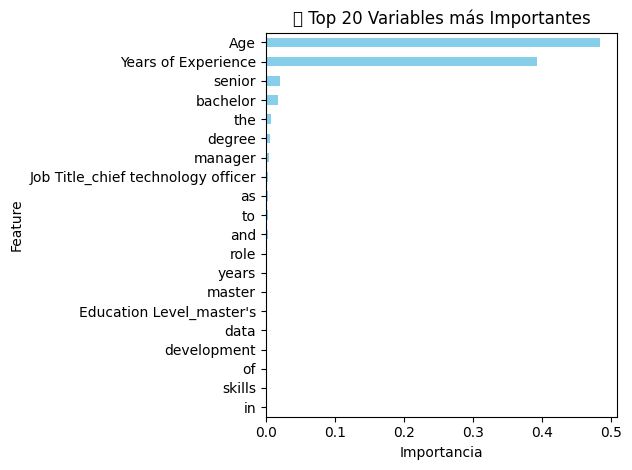

In [18]:
import matplotlib.pyplot as plt

# 🔍 Importancia de features
importances = model.feature_importances_
feature_names = X.columns

# 🧱 Crear DataFrame ordenado
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 📊 Gráfico
plt.figure(figsize=(12, 8))
importances_df.head(20).plot(kind='barh', x='Feature', y='Importance', legend=False, color='skyblue')
plt.title('📌 Top 20 Variables más Importantes')
plt.xlabel('Importancia')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## ✅ Conclusiones Finales

Este análisis permitió construir un modelo de predicción de salarios a partir de características estructuradas y texto libre, logrando métricas de desempeño destacables:

- 🔍 El modelo combinó variables numéricas, categóricas y texto de descripciones de puestos.
- 📈 Las métricas alcanzadas incluyen un R² de aproximadamente 0.87, lo cual indica una buena capacidad explicativa del modelo.
- 🧠 Las variables más influyentes fueron la edad, los años de experiencia y ciertas palabras clave en las descripciones como "senior", "bachelor", "manager".

**Posibles mejoras futuras:**
- Utilizar embeddings como Word2Vec o BERT para mejorar la representación de texto.
- Ajuste de hiperparámetros con técnicas como Grid Search o Random Search.
- Validación cruzada para aumentar la robustez del modelo.
- Añadir más datos y enriquecer los features.

---
Este proyecto demuestra cómo un enfoque integral de ciencia de datos puede aportar valor mediante modelos interpretables y efectivos en contextos reales como la predicción salarial.
